In [1]:
__author__ = "Zewei 'Jason' Wu <wuz25@uchicago.edu>"
__version__ = '20230518'  # yyyymmdd; version datestamp of this notebook
__datasets__ = ['The Baryon Oscillation Spectroscopic Survey (BOSS)', 'SDSS DR12']  # datasets used in this notebook
__keywords__ = ['sdss', 'SDSS', 'galaxies', 'quasars']  # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/astro-datalab/notebooks-latest/blob/master/keywords.txt

# Characterizing the Baryonic Acoustic Oscillation from BOSS

*Jason Wu. Department of Astronomy and Astrophysics, The University of Chicago*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [1. Loading galaxy data](#galaxy_data)
* [2. (optional) Calibration](#calibration)
* [3. Visualizing the dataset](#visualization)
* [4. Loading random data](#randoms)
* [5. Two-Point correlation function](#correlation)
* [6. Co-Moving distances](#distance)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals

* Load and characterize data
* Performs two-point correlation
* Compute co-moving spatial distance
* Replicate plots in [Eisenstein et al 2004](https://iopscience.iop.org/article/10.1086/466512) and [Anderson et al 2012](https://arxiv.org/abs/1203.6594)

# Summary

In this notebook, we construct a simple 3d co-moving spatial correlation function from the [The Baryon Oscillation Spectroscopic Survey (BOSS)](https://fbeutler.github.io/hub/boss_papers.html), which is a part of the [SDSS DR12](https://www.sdss4.org/dr12/).

Two definitions of co-moving distances are used from influential papers regarding the topic: [Eisenstein et al 2004](https://iopscience.iop.org/article/10.1086/466512) and [Anderson et al 2012](https://arxiv.org/abs/1203.6594) respectively. From the plots, we discern a baryonic acoustic oscillation (BAO) imprint at the typical distance scale of $100\ h^{-1} {\rm Mpc}$.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

The following two cells setup the imports as well as the graphing parameters.

Note the second cell relies on `data/def.mplstyle` to run, so make sure to copy the full directory.

In [2]:
# Standard python imports
%matplotlib inline

# system imports
from os.path import join
import os
import glob
import inspect
from importlib import reload
import warnings

# standard scientific computing imports
import numpy as np
import pylab as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import pandas as pd

# astropy imports
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy import constants as const
import astropy.units as u
from astropy.io import fits

# healpy is a visualization library for spherical coordinates
import healpy as hp
# treecorr is used to construct two-point correlation functions
import treecorr

In [3]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('data/def.mplstyle')

def plot_prettier(dpi=200, fontsize=10, usetex=True): 
    '''
    Make plots look nicer compared to Matplotlib defaults
    Parameters: 
        dpi - int, "dots per inch" - controls resolution of PNG images that are produced
                by Matplotlib
        fontsize - int, font size to use overall
        usetex - bool, whether to use LaTeX to render fonds of axes labels 
                use False if you don't have LaTeX installed on your system
    '''
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    # if you don't have LaTeX installed on your laptop and this statement 
    # generates error, comment it out
    plt.rc('text', usetex=usetex)
plot_prettier(dpi=400, usetex=False)

<a class="anchor" id="galaxy_data"></a>
# Loading Galaxy Data

Load the data from the Baryon Oscillation Spectroscopic Survey (BOSS).

Only the Southern half of the survey is used. The analysis could extend to the full dataset, but this is sufficient for the purposes of seeing the BAO.

The dataset is pre-selected for Luminous Red Galaxies (LRGs) with two color cuts for $z < {\rm and} > 0.45$. The specifics are noted in this [SDSS page](https://classic.sdss.org/dr7/products/general/edr_html/node53.html).

In [4]:
# relative path to the working directory
rel_path = '/'.join(os.getcwd().split('/')[5:])
rel_path

'datalab_contrib/05_Contrib/ExtraGalactic/BaryonicAcousticOscillations'

In [5]:
filename = 'data/galaxy_DR12v5_CMASSLOWZTOT_South.fits'

# download the file if it doesn't exist
if os.path.exists(filename):
    print(f'File found at {filename}')
else:
    !wget --no-check-certificate -P {rel_path}/data/ https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz
    !gzip -d {rel_path}/data/galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz

File found at data/galaxy_DR12v5_CMASSLOWZTOT_South.fits


In [6]:
data = fits.open(filename)[1].data

Number of objects in the dataset

In [7]:
print(f'{len(data)} points in total in data')

372601 points in total in data


Print out all the data fields

In [8]:
data.names

['RA',
 'DEC',
 'RUN',
 'RERUN',
 'CAMCOL',
 'FIELD',
 'ID',
 'ICHUNK',
 'IPOLY',
 'ISECT',
 'FRACPSF',
 'EXPFLUX',
 'DEVFLUX',
 'PSFFLUX',
 'MODELFLUX',
 'FIBER2FLUX',
 'R_DEV',
 'EXTINCTION',
 'PSF_FWHM',
 'AIRMASS',
 'SKYFLUX',
 'EB_MINUS_V',
 'IMAGE_DEPTH',
 'IMATCH',
 'Z',
 'WEIGHT_FKP',
 'WEIGHT_CP',
 'WEIGHT_NOZ',
 'WEIGHT_STAR',
 'WEIGHT_SEEING',
 'WEIGHT_SYSTOT',
 'NZ',
 'COMP',
 'PLATE',
 'FIBERID',
 'MJD',
 'FINALN',
 'TILE',
 'SPECTILE',
 'ICOLLIDED',
 'INGROUP',
 'MULTGROUP']

<a class="anchor" id="calibration"></a>
# Magnitude Calibration

The magnitudes are given in five different versions of fluxes, with the same definitions as [Eisenstein et al 2004](https://iopscience.iop.org/article/10.1086/466512).

Eisenstein uses SDSS DR9, which has the same data structure as DR12, we can apply the same color and magnitude cuts on our data. This section constructs a `pandas DataFrame` object and performs the afrementioned cuts on the data.

However, this data cut skews the random dataset as they do not have flux data. To see the BAO with 3d correlation, the two datasets need to share a similar distribution in the redshift-space. Therefore, in the last cell of this section `gal_df_cut` is set as a copy of the original `gal_df`. Comment out this line if you wish to see the results with the data cut.

In [9]:
# ugriz bands
u_mod, g_mod, r_mod, i_mod, z_mod = data['MODELFLUX'].T  # mod
u_cmod, g_cmod, r_cmod, i_cmod, z_cmod = data['EXPFLUX'].T  # cmod
u_psf, g_psf, r_psf, i_psf, z_psf = data['PSFFLUX'].T  # psf
u_fib2, g_fib2, r_fib2, i_fib2, z_fib2 = data['FIBER2FLUX'].T  # fib2

To get magnitudes from flux data, we use the zero points as indicated by [SDSS](https://www.sdss4.org/dr13/algorithms/magnitudes/#:~:text=The%20relation%20between%20detected%20flux,with%20conventional%20magnitude%20of%20zero):

In [10]:
params_df = pd.DataFrame({
    'Filter': 'u g r i z'.split(),
    'm0': [22.12, 22.60, 22.29, 21.85, 20.32],
}).set_index('Filter')
params_df

,m0
Filter,
u,22.12
g,22.60
r,22.29
i,21.85
z,20.32


In [11]:
# calculate magnitudes
mags = []
flux_arr = [np.array([u_mod, u_cmod, u_psf, u_fib2]),
            np.array([g_mod, g_cmod, g_psf, g_fib2]),
            np.array([r_mod, r_cmod, r_psf, r_fib2]),
            np.array([i_mod, i_cmod, i_psf, i_fib2]),
            np.array([z_mod, z_cmod, z_psf, z_fib2])]
for i, flux in enumerate(flux_arr):
    m0 = params_df.iloc[i][0]
    flux = np.clip(flux, 3, None)
    mag = m0 - 2.5 * np.log10(flux)
    mags.append(mag)
    
umag, gmag, rmag, imag, zmag = mags
[u_mod, u_cmod, u_psf, u_fib2] = umag
[g_mod, g_cmod, g_psf, g_fib2] = gmag
[r_mod, r_cmod, r_psf, r_fib2] = rmag
[i_mod, i_cmod, i_psf, i_fib2] = imag
[z_mod, z_cmod, z_psf, z_fib2] = zmag

Apply the magnitude cuts in Eisenstein 2004.

In [12]:
prop_arr = np.array([data['RA'], data['DEC'], data['ID'], data['Z'],
                     u_mod, u_cmod, u_psf, u_fib2,
                     g_mod, g_cmod, g_psf, g_fib2,
                     r_mod, r_cmod, r_psf, r_fib2,
                     i_mod, i_cmod, i_psf, i_fib2,
                     z_mod, z_cmod, z_psf, z_fib2]).T
columns='RA, DEC, ID, Z, u_mod, u_cmod, u_psf, u_fib2, g_mod, g_cmod, g_psf, g_fib2, r_mod, r_cmod, r_psf, r_fib2, i_mod, i_cmod, i_psf, i_fib2, z_mod, z_cmod, z_psf, z_fib2'.split(', ')
gal_df = pd.DataFrame(prop_arr, columns=columns)
gal_df.head(5)

,RA,DEC,ID,Z,u_mod,u_cmod,u_psf,u_fib2,g_mod,g_cmod,...,r_psf,r_fib2,i_mod,i_cmod,i_psf,i_fib2,z_mod,z_cmod,z_psf,z_fib2
0,321.480329,9.973440,517.0,0.301401,20.927198,20.927198,20.927198,20.927198,21.407198,21.407198,...,20.582914,20.724066,18.783108,18.678005,19.181156,19.753801,16.946892,17.033537,17.303925,17.882273
1,321.359691,9.933358,887.0,0.458872,20.927198,20.927198,20.927198,20.927198,21.407198,21.407198,...,20.770262,21.097198,18.562006,18.844593,19.473707,20.088095,16.602465,16.595581,17.445007,18.179171
2,322.614181,10.144496,426.0,0.579383,20.927198,20.927198,20.927198,20.927198,21.407198,21.407198,...,21.097198,21.097198,19.080805,19.534019,19.917955,20.649508,17.473509,17.705313,18.276144,18.923445
3,325.011054,10.531999,1874.0,0.672858,20.927198,20.927198,20.927198,20.927198,21.407198,21.407198,...,21.097198,21.097198,19.539892,19.632660,20.489014,20.657198,17.524124,17.613770,18.356428,18.802851
4,325.200214,10.495498,250.0,0.517716,20.927198,20.927198,20.927198,20.927198,21.407198,21.407198,...,21.097198,21.097198,18.697245,19.153563,19.844528,20.083010,16.574615,16.958355,17.593666,18.047581


In [13]:
gal_df_ = gal_df.copy()
d_p = gal_df.r_mod - gal_df.i_mod - (gal_df.g_mod - gal_df.r_mod) / 8.0
# create the mask with different conditions
mask = np.logical_and(gal_df.i_cmod > 17.5, gal_df.i_cmod < 19.9)
mask = np.logical_and(mask, gal_df.r_mod - gal_df.i_mod < 2.0)
mask = np.logical_and(mask, d_p > 0.55)
mask = np.logical_and(mask, gal_df.i_fib2 < 21.5)
mask = np.logical_and(mask, gal_df.i_cmod < 19.86 + 1.6 * (d_p - 0.8))
mask = np.logical_and(mask, gal_df.i_psf - gal_df.i_mod > 0.2 + 0.2 * (20.0 - gal_df.i_mod))
mask = np.logical_and(mask, gal_df.z_psf - gal_df.z_mod > 9.125 - 0.46 * gal_df.z_mod)

Show the number of objects cut and remaining:

In [14]:
gal_df_cut = gal_df_.where(mask).dropna()
print(f'{len(gal_df) - len(gal_df_cut)} entries cut, {len(gal_df_cut)} remaining')

359304 entries cut, 13297 remaining


In [15]:
"""Comment out this line if you wish to see the results with the data cut."""
gal_df_cut = gal_df.copy().dropna()

<a class="anchor" id="visualization"></a>
# Visualization of the Dataset

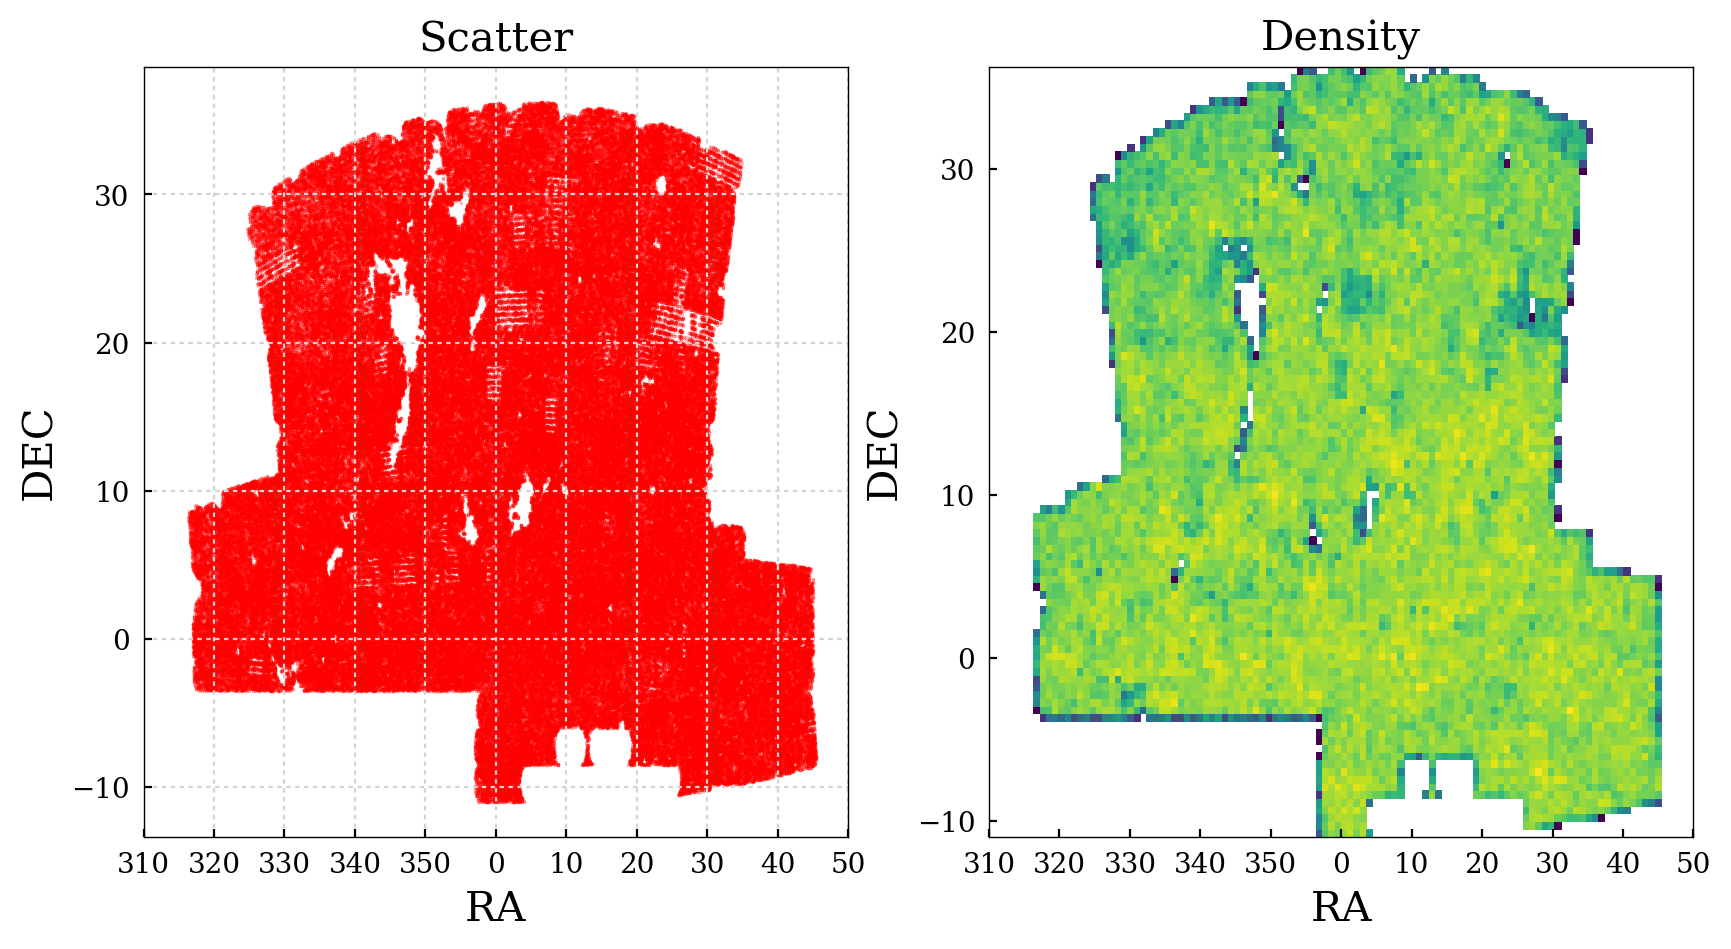

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=200)

# scatter plot on left
ax1.set_title('Scatter')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
wrapped_ind = gal_df_cut['RA'] < 100
wrapped_ra = gal_df_cut['RA']
wrapped_ra[wrapped_ind] += 360
ax1.scatter(wrapped_ra, gal_df_cut['DEC'], marker='.', s=0.2, alpha=0.5, c='red')
xticks = np.arange(310, 420, 10)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks%360)

# density plot on right
ax2.set_title('Density')
ax2.set_xlabel('RA')
ax2.set_ylabel('DEC')
wrapped_ind = gal_df_cut['RA'] < 100
wrapped_ra = gal_df_cut['RA']
wrapped_ra[wrapped_ind] += 360
ax2.hist2d(wrapped_ra, gal_df_cut['DEC'], bins=100, norm=LogNorm())
xticks = np.arange(310, 420, 10)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks%360)

plt.show()

Show a mollwide visualization with the `healpy` module

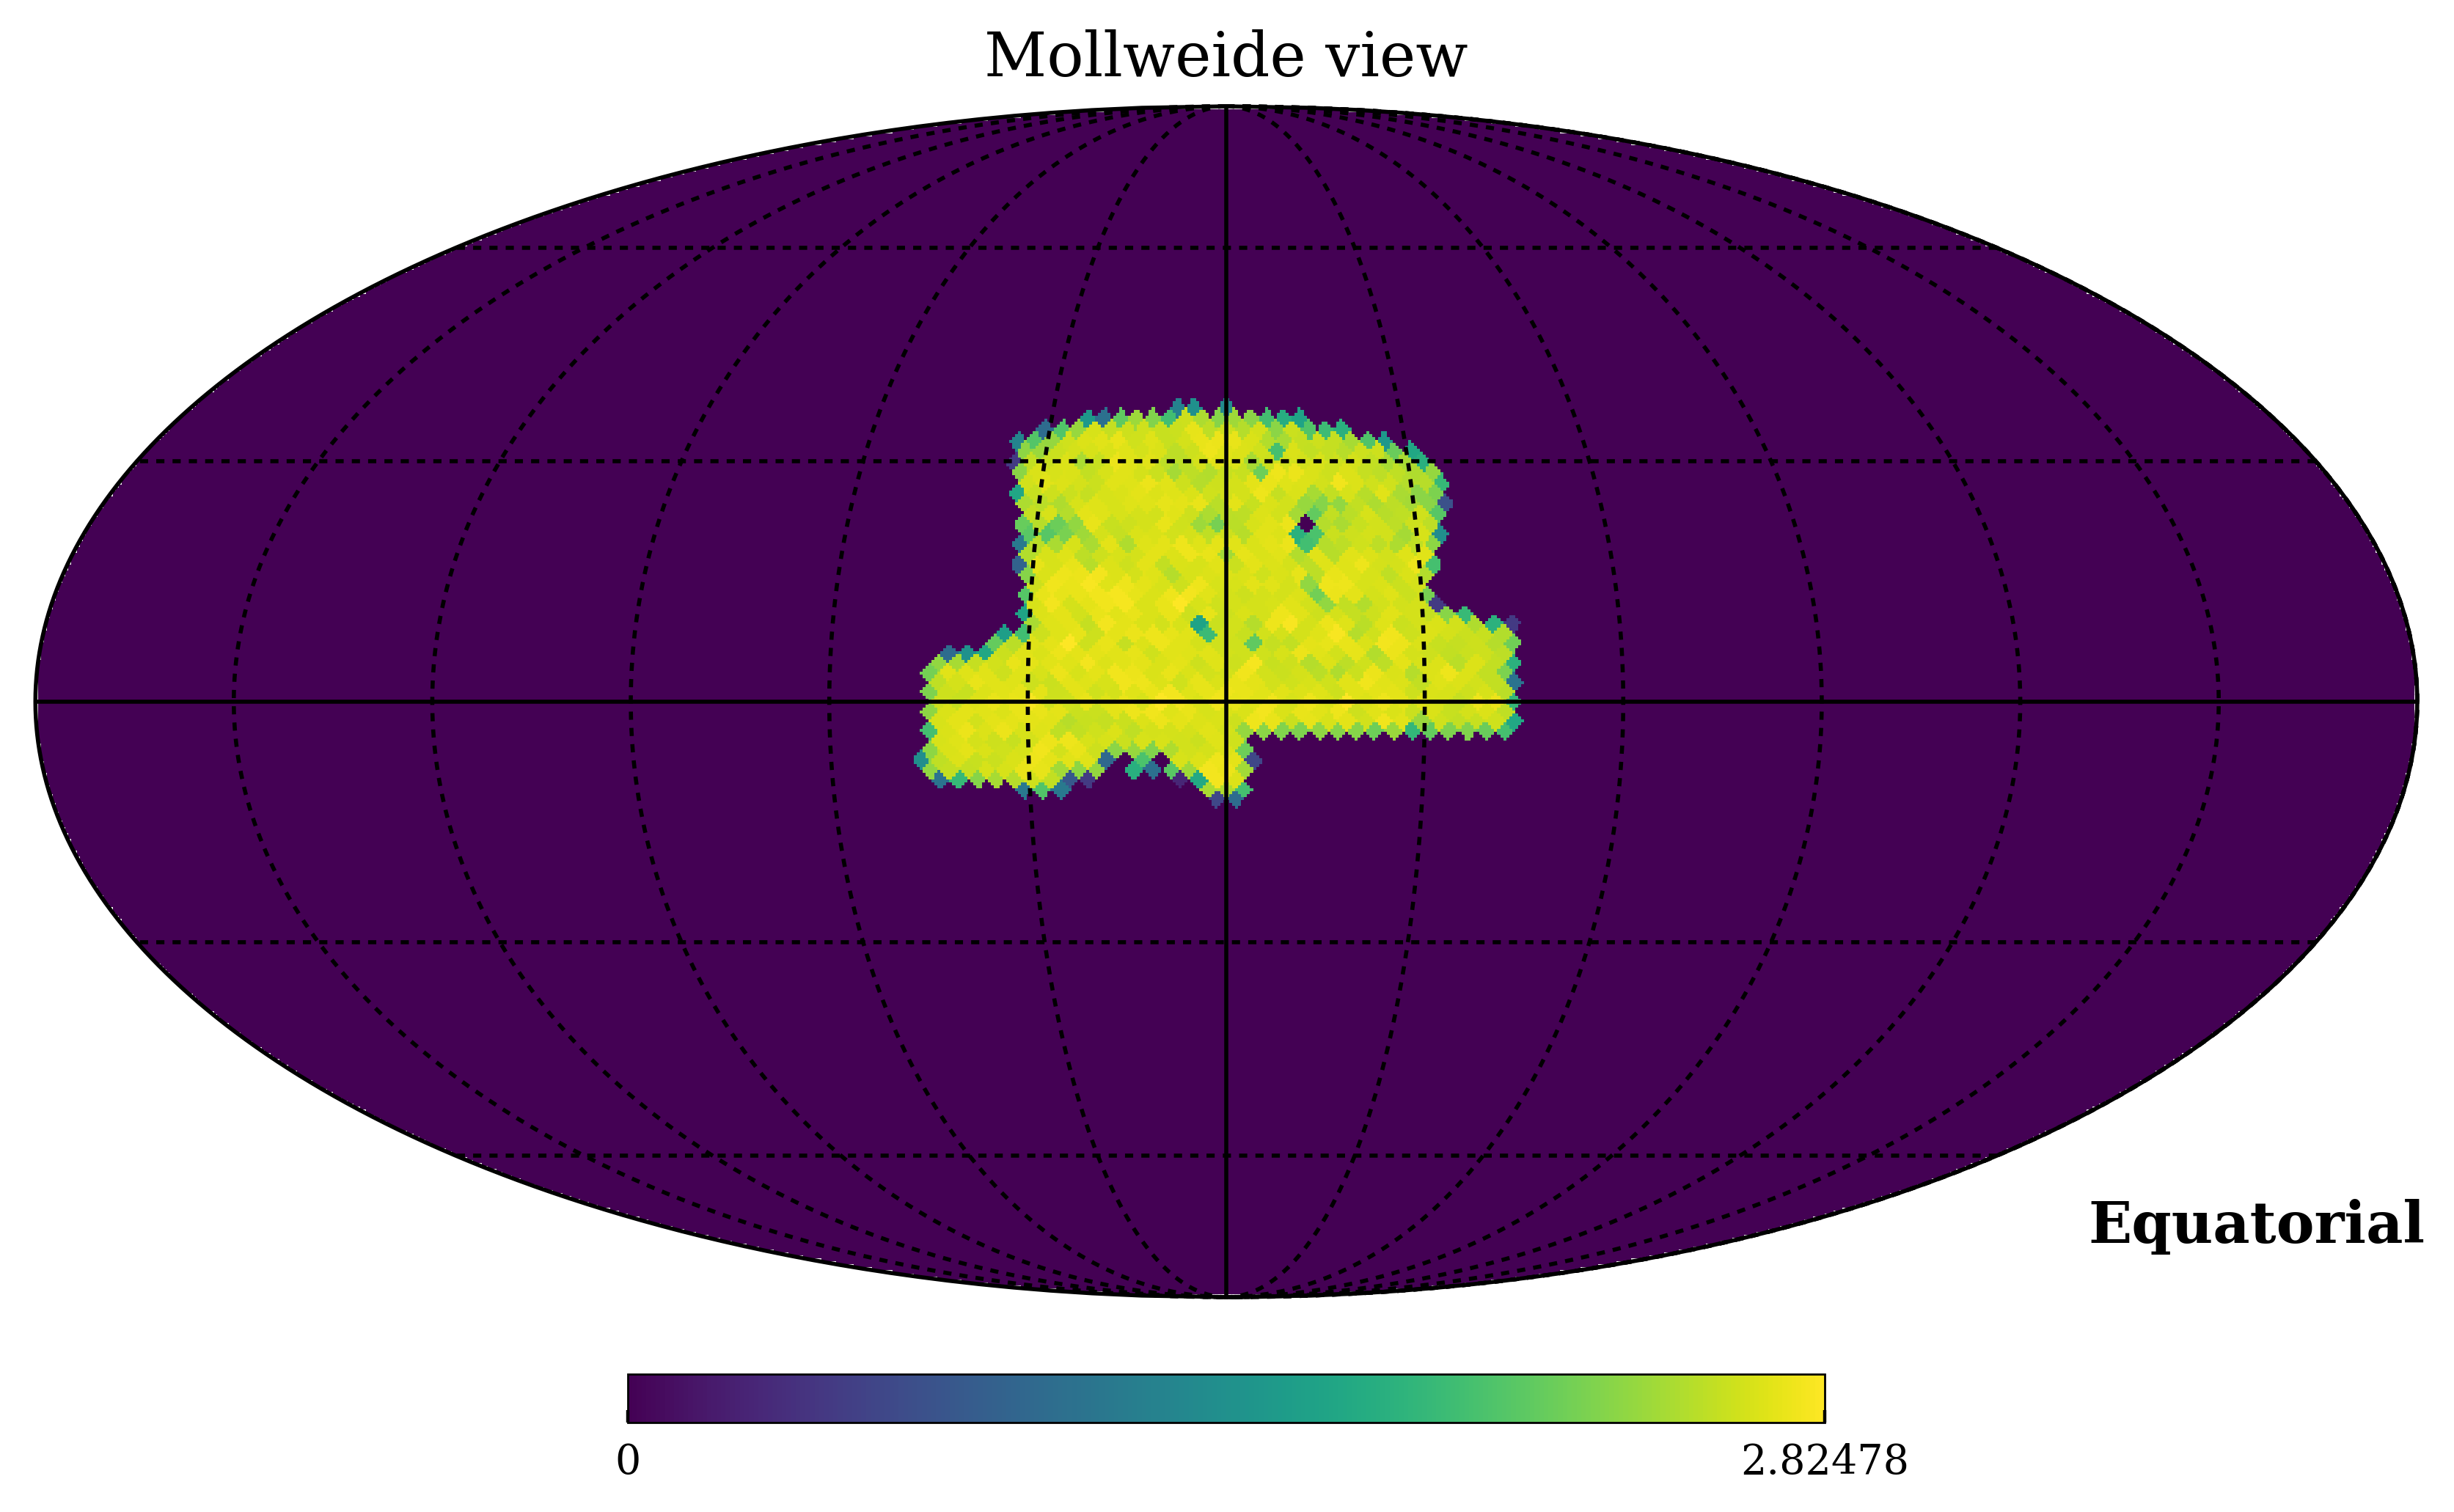

In [17]:
# healpy visualization
NSIDE = 32
# coords in the catalog
COORDS = SkyCoord(gal_df_cut['RA'], gal_df_cut['DEC'], unit=['deg','deg'])

# convert catalog coords to index of pixels
pix_ind = hp.ang2pix(NSIDE, COORDS.ra.value, COORDS.dec.value, lonlat=True)

unique_ind, density = np.unique(pix_ind, return_counts=True)
full_density = np.ones(hp.nside2npix(NSIDE))  # to remove gaps for the undersampled regions
full_density[unique_ind] = density

hp.mollview(np.log10(full_density), coord='C')  # C = celestial equatorial
hp.graticule()
plt.show()

<a class="anchor" id="randoms"></a>
# Loading Radom Data

Random data is also from SDSS, and takes into account the instrumental bias, as well as selection bias of the survey. This is so that we wouldn't have to propagate the selection function.

In [18]:
filename = 'data/random0_DR12v5_CMASSLOWZTOT_South.fits'

# download the file if it doesn't exist
if os.path.exists(filename):
    print(f'File found at {filename}')
else:
    !wget --no-check-certificate -P {rel_path}/data/ https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASSLOWZTOT_South.fits.gz
    !gzip -d {rel_path}/data/random0_DR12v5_CMASSLOWZTOT_South.fits.gz

File found at data/random0_DR12v5_CMASSLOWZTOT_South.fits


In [19]:
rand = fits.open(filename)[1].data

In [20]:
print(f'{len(rand)} points in total in random')

18544998 points in total in random


In [21]:
rand.names

['RA',
 'DEC',
 'Z',
 'WEIGHT_FKP',
 'NZ',
 'IPOLY',
 'ISECT',
 'ZINDX',
 'SKYFLUX',
 'IMAGE_DEPTH',
 'AIRMASS',
 'EB_MINUS_V',
 'PSF_FWHM']

In [22]:
# subselect the same number of samples
rand_cut = np.random.choice(rand, size=len(gal_df_cut), replace=False)

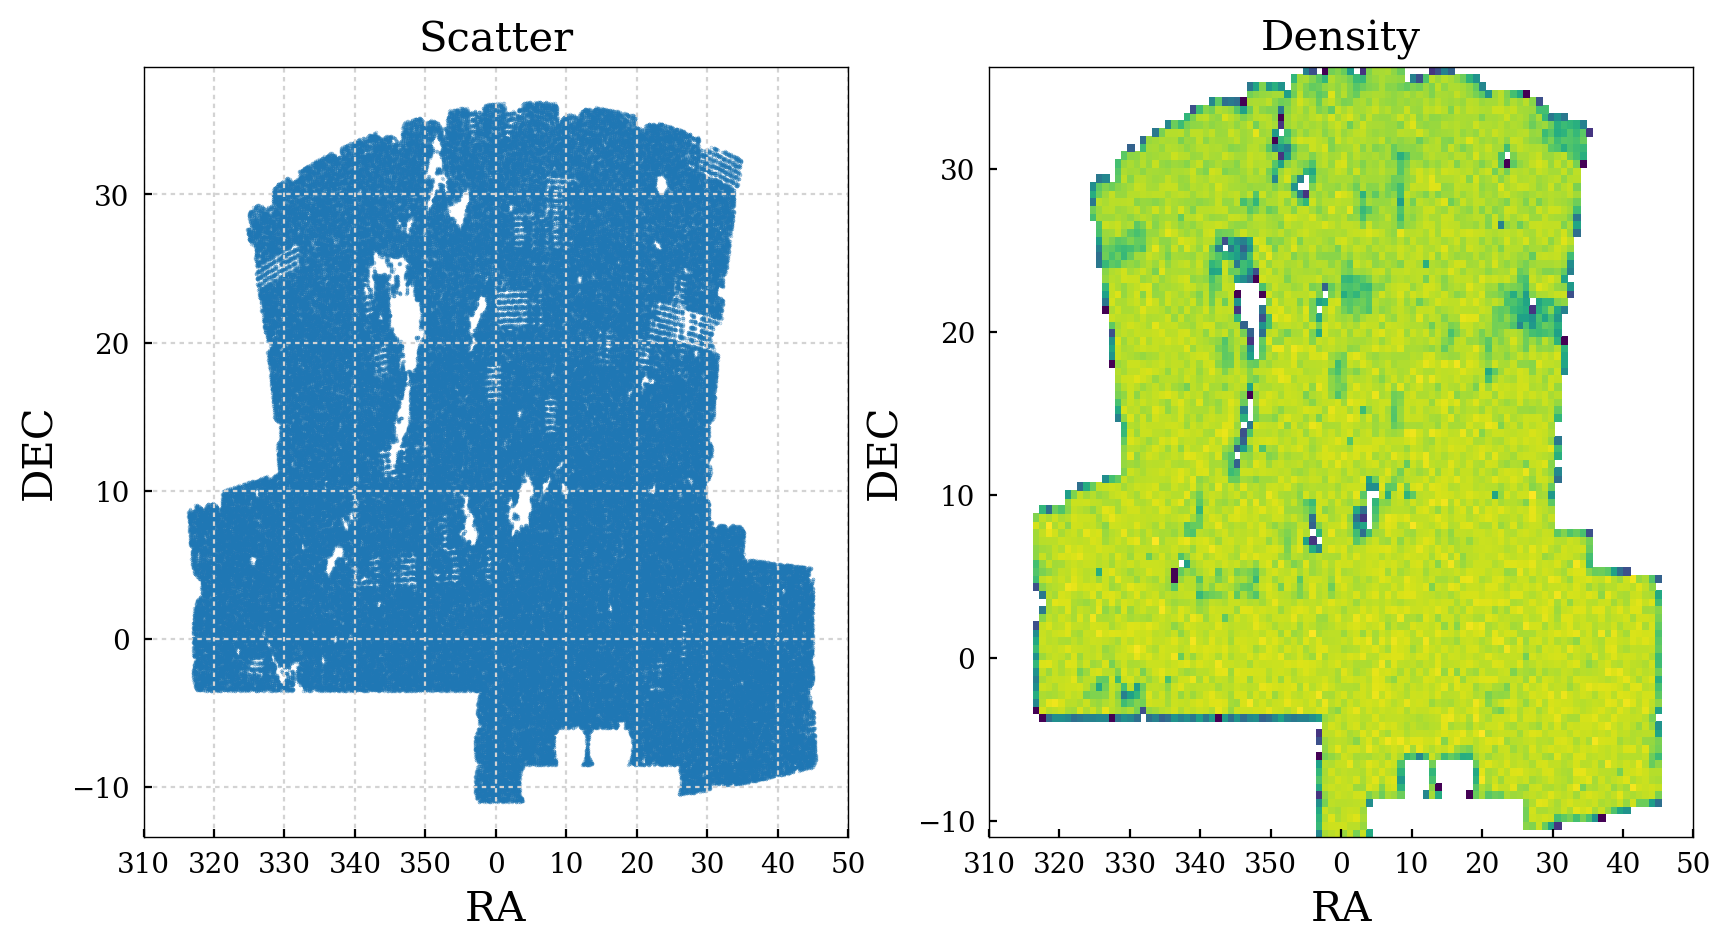

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=200)

# scatter plot on left
ax1.set_title('Scatter')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
wrapped_ind = rand_cut['RA'] < 180
wrapped_ra = rand_cut['RA']
wrapped_ra[wrapped_ind] += 360
ax1.scatter(wrapped_ra, rand_cut['DEC'], marker='.', s=0.2, alpha=0.5, c='C0')
xticks = np.arange(310, 420, 10)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks%360)

# density plot on right
ax2.set_title('Density')
ax2.set_xlabel('RA')
ax2.set_ylabel('DEC')
wrapped_ind = rand_cut['RA'] < 100
wrapped_ra = rand_cut['RA']
wrapped_ra[wrapped_ind] += 360
ax2.hist2d(wrapped_ra, rand_cut['DEC'], bins=100, norm=LogNorm())
xticks = np.arange(310, 420, 10)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks%360)

plt.show()

Print the number of data points in the galaxy and random set

In [24]:
len(gal_df_cut), len(rand_cut)

(372601, 372601)

## Distribution in redshift-space

As mentioned in the previous section, the galaxy and random datasets need to share a similar distribution in the redshift-space, in order to see the BAO with this type of 3d correlation.

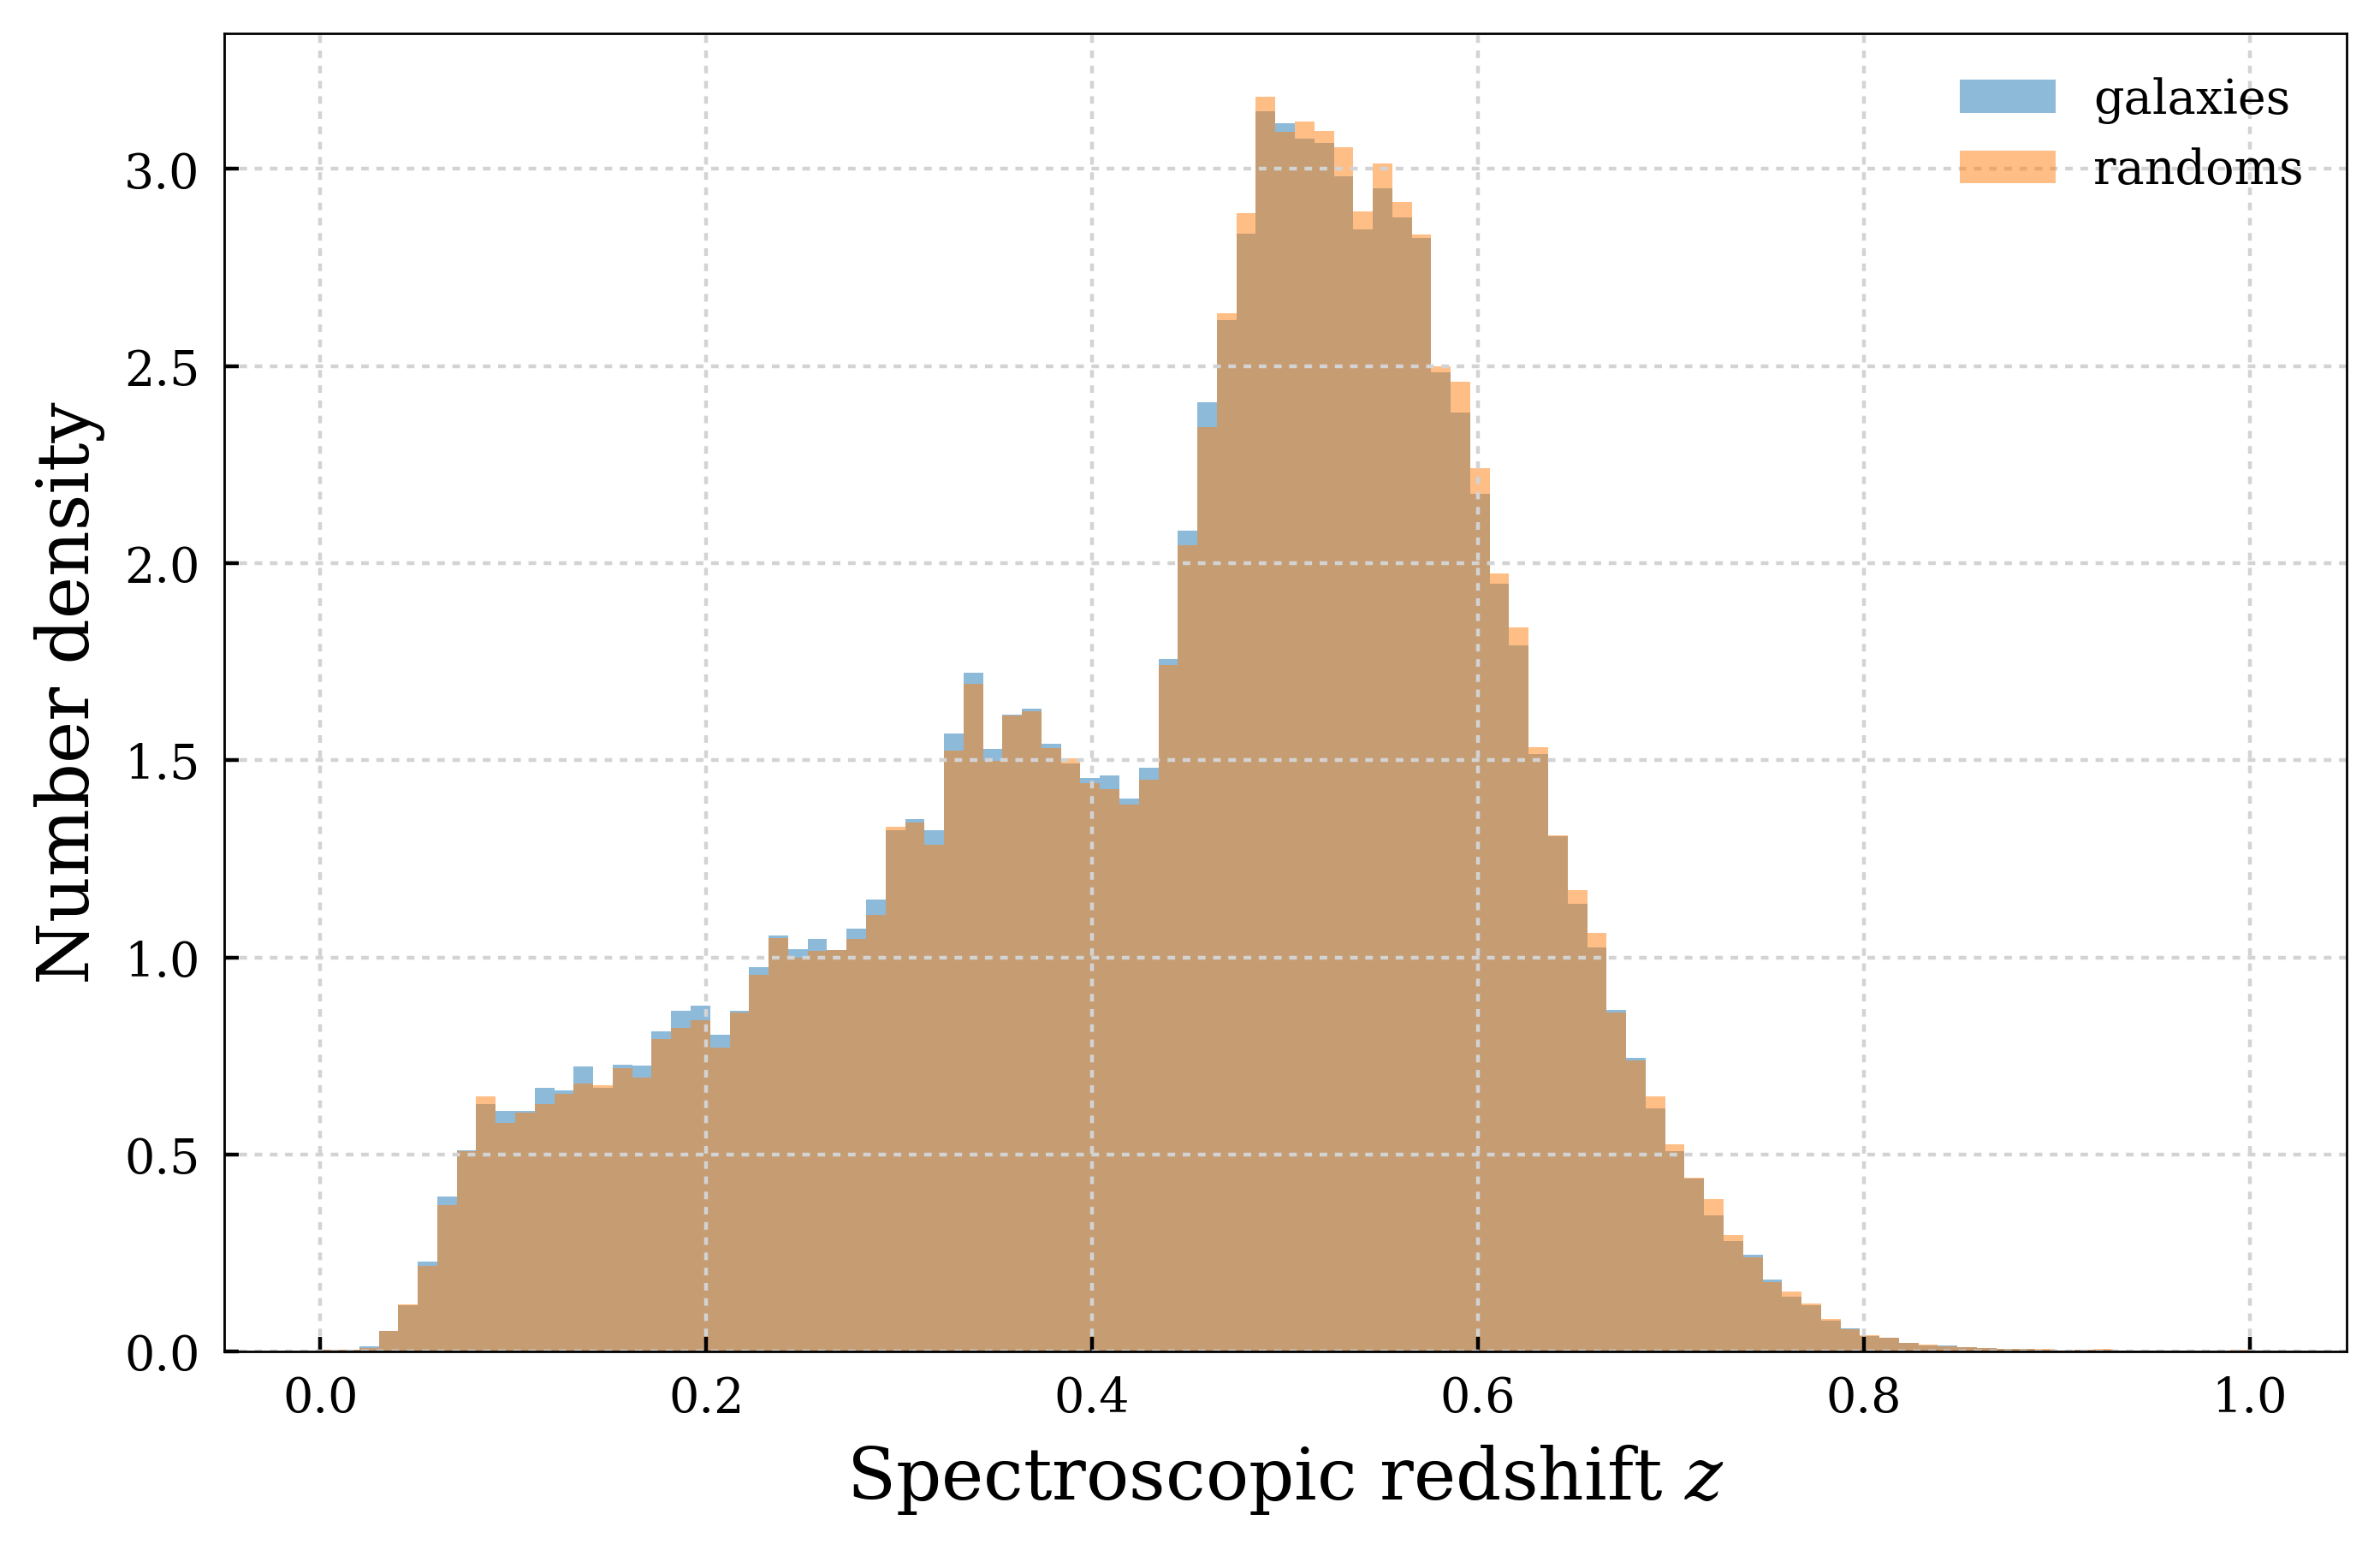

In [25]:
plt.figure(figsize=(8,5))
plt.hist(gal_df_cut['Z'], alpha=0.5, label='galaxies', bins=np.linspace(0, 1, 100), density=1)
plt.hist(rand_cut['Z'], alpha=0.5, label='randoms', bins=np.linspace(0, 1, 100), density=1)
plt.legend()
plt.xlabel('Spectroscopic redshift $z$')
plt.ylabel('Number density')
plt.show()

<a class="anchor" id="correlation"></a>
# Two-Point correlation function

To construct the correlation function, the data points have to be mapped onto three-dimensional space. This is done with co-moving distances inferred from spectroscopic redshifts of the objects.

For the purposes of our analysis, we use flat ΛCDM paradigm as the cosmology of our universe.

In [26]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

In [27]:
# value of h-unit
h = cosmo.H(0).value / 100
h

0.7

Calculate two-point correlation functions for data and random.

This is done using the [Landy-Szalay et al 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...412...64L/abstract) formula:

$$\frac{dd-2dr+rr}{rr},$$

which is known to accurately reproduce small-scale structures like galaxy clusters, as well as large-scale cosmologies like the BAO peak. It also has an error estimation which could be easily calculated.

In [28]:
def tpcf_ls(D_gal, D_rand, ra_gal, dec_gal, ra_rand, dec_rand,
            min_sep=10, max_sep=200, bin_size=5):  # binning analysis
    # cosmology
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
    h = cosmo.H(0).value / 100
    
    """Cartesian coordinates in co-moving frame"""
    # for member galaxies in catalog
    dec_gal_rad = dec_gal.to(u.rad)  # convert to radians
    ra_gal_rad = ra_gal.to(u.rad)
    xgal = D_gal * np.cos(dec_gal_rad) * np.cos(ra_gal_rad)
    ygal = D_gal * np.cos(dec_gal_rad) * np.sin(ra_gal_rad)
    zgal = D_gal * np.sin(dec_gal_rad)
    # for member galaxies in random
    dec_rand_rad = dec_rand.to(u.rad)  # convert to radians
    ra_rand_rad = ra_rand.to(u.rad)
    xrand = D_rand * np.cos(dec_rand_rad) * np.cos(ra_rand_rad)
    yrand = D_rand * np.cos(dec_rand_rad) * np.sin(ra_rand_rad)
    zrand = D_rand * np.sin(dec_rand_rad)
    
    # filter the NANs
    mask = np.logical_and(~np.isnan(xgal), ~np.isnan(xrand))
    g_cat = treecorr.Catalog(x=xgal[mask],
                             y=ygal[mask],
                             z=zgal[mask])
    r_cat = treecorr.Catalog(x=xrand[mask],
                             y=yrand[mask],
                             z=zrand[mask])

    """Run the correlation function"""
    # define dd
    dd = treecorr.NNCorrelation(min_sep=min_sep, max_sep=max_sep, bin_size=bin_size, bin_type='Linear')
    dd.process(g_cat)

    # define rr
    rr = treecorr.NNCorrelation(min_sep=min_sep, max_sep=max_sep, bin_size=bin_size, bin_type='Linear')
    rr.process(r_cat)

    # define dr
    dr = treecorr.NNCorrelation(min_sep=min_sep, max_sep=max_sep, bin_size=bin_size, bin_type='Linear')
    dr.process(g_cat, r_cat)

    # error calculations
    xi, varxi = dd.calculateXi(rr, dr)  # value and error
    r = np.exp(dd.meanlogr)  # bins
    rh = r  # in Mpc/h
    r = r/h  # in Mpc
    sig = np.sqrt(varxi)
    
    return r, rh, xi, sig

In [29]:
def tpcf_plot(r, rh, xi, sig,
              xlog=False, ylog=False,                            # log the axis
              xmin=10, xmax=150, xlabels=np.arange(0, 160, 20),  # x-axis
              ymin=-30, ymax=20,                                 # y-axis
              fig_path='graphs/ls_spatial_correlation'):
    """Plot the r^2 xi correlations"""
    fig, ax = plt.subplots(figsize=(8,5), dpi=300)
    # plot value and error
    ax.errorbar(rh, (r**2) * xi, yerr=(r**2) * sig, color='blue',
                marker='o', markersize=5, lw=2, ls='',
                elinewidth=1, capsize=0, alpha=1)

    # axis parameters
    if xlog:
        ax.set_xscale('log', nonpositive='clip')
    ax.set_title('L-S Spatial Correlation')
    # x-axis
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'${\rm Comoving\ Separation\ } r\ (h^{-1} {\rm Mpc})$')
    ax.set_xticks(xlabels)
    ax.set_xticklabels(xlabels)
    ax.tick_params(top=True, right=True)
    # y-axis
    if ylog:
        ax.set_yscale('log', nonpositive='clip')
    ax.set_ylabel(r'$r^2 \xi(r)$')
    ax.set_ylim(ymin, ymax)
    plt.show()
    fig.savefig(fig_path)

### RA and DEC of the galaxies

In [30]:
# fetch for both catalog and randoms
ra_gal = (gal_df_cut['RA'].to_numpy() * u.deg)
dec_gal = (gal_df_cut['DEC'].to_numpy() * u.deg)
ra_rand = (rand_cut['RA'] * u.deg)
dec_rand = (rand_cut['DEC'] * u.deg)

<a class="anchor" id="distance"></a>
# Co-Moving Distances

## Replicating [Eisenstein et al 2004](https://iopscience.iop.org/article/10.1086/466512)
### Using traditional co-moving distance

Withou using any arbitrary criteria, the traditional definition for comoving distance is as follows:

$$d_C(z) = d_H \int_0^z \frac{dz'}{E(z')}$$

We use the `cosmo.comoving_distance(z)` function in the `astropy` module to simplify our calculations.

In [31]:
# code without using criteria in rs
# comoving distance for galaxies
D_gal = cosmo.comoving_distance(gal_df_cut['Z'].to_numpy()) * h  # h^-1 * Mpc
# comoving distance for randoms
D_rand = cosmo.comoving_distance(rand_cut['Z']) * h  # h^-1 * Mpc

In [32]:
r, rh, xi, sig = tpcf_ls(D_gal, D_rand, ra_gal, dec_gal, ra_rand, dec_rand,
                         min_sep=10, max_sep=200, bin_size=5)

/data0/sw/astr285_kernel/anaconda3/lib/python3.8/site-packages/treecorr/util.py:665: FutureWarning: Use of keyword-only arguments as positional arguments is deprecated in the function calculateXi. The following parameters now require an explicit keyword name: ['rr', 'dr']
  warnings.warn(


### Figures

The correlation function $\xi(r)$ obtained from `treecorr` is multiplied with $r^2$ to better demonstrate the peak.

Note that the error estimate used here is without any bootstrap methods with regards to different patches.

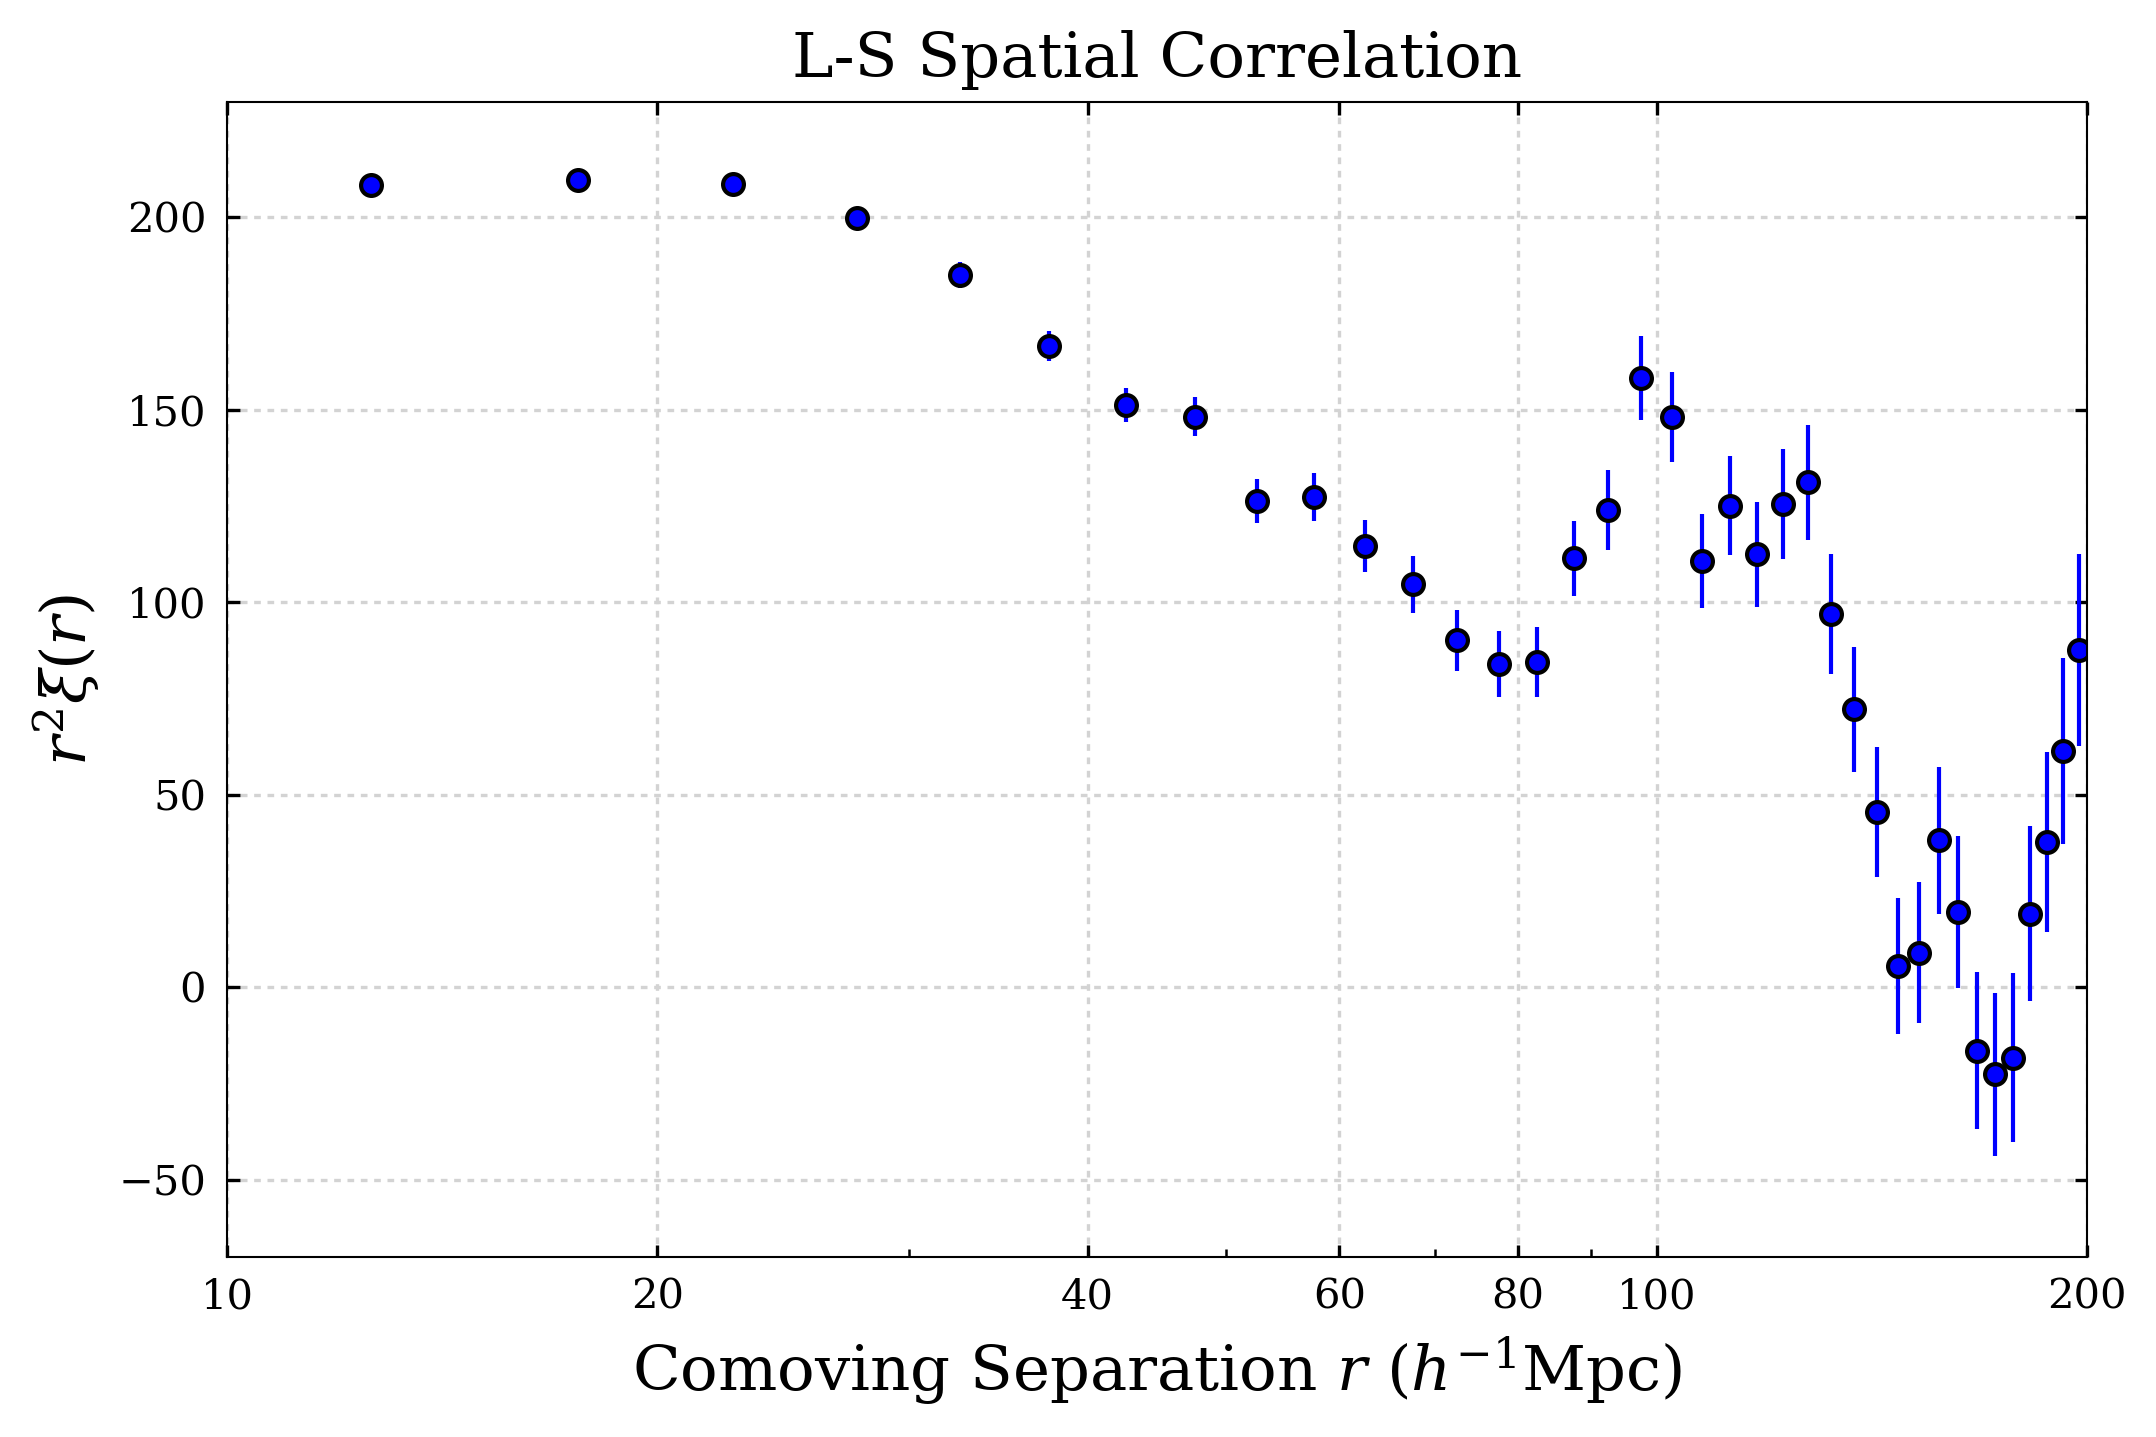

In [33]:
xmin, xmax = 10, 200
ymin, ymax = -70, 230
xlabels = [10, 20, 40, 60, 80, 100, 200]

tpcf_plot(r, rh, xi, sig,
          xlog=True, ylog=False,                             # log the axis
          xmin=xmin, xmax=xmax, xlabels=xlabels,             # x-axis
          ymin=ymin, ymax=ymax,                              # y-axis
          fig_path='graphs/spatial_eisenstein')

## Replicating [Anderson et al 2012](https://arxiv.org/abs/1203.6594)
### Using Sound Horizon

To obtain a 3d spatial correlation function, co-moving distances must be calculated for all data points in galaxy and random.

$$D_V \equiv {[cz(1+z)^2D_A^2H^{-1}]}^{1/3}$$

This is done with the same assumptions in Anderson et al 2012, using fiducial values $(D_V/r_s)_{\rm fid} = 13.23$ of co-moving distance $D_V$ and sounds horizon $r_s$ as defined in Eisenstein & Hu 1998.

In [34]:
# distance parameter r_s
def calc_rs(z, alpha = 1):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
    D_a = cosmo.angular_diameter_distance(z)  # the angular diameter distance
    # comoving distance
    H = cosmo.H(z)
    D_v = (const.c * z * (1+z)**2 * D_a**2 * H**(-1)) ** (1/3)
    rs = D_v / 13.23 / alpha
    return rs.to(u.Mpc)  # convert to Mpc

# calculate sound horizon rs values
D_gal = calc_rs(z=gal_df_cut['Z'].to_numpy()) * h  # h^-1 * Mpc
D_rand = calc_rs(z=rand_cut['Z']) * h  # h^-1 * Mpc

/data0/sw/astr285_kernel/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


The following cells may take a few minutes to run. The goal is to experiment with different bin sizes. The one you use for plotting is determined by the Figures cell below.

In [35]:
r_2, rh_2, xi_2, sig_2 = tpcf_ls(D_gal, D_rand, ra_gal, dec_gal, ra_rand, dec_rand,
                         min_sep=10, max_sep=200, bin_size=2)

In [36]:
r_5, rh_5, xi_5, sig_5 = tpcf_ls(D_gal, D_rand, ra_gal, dec_gal, ra_rand, dec_rand,
                         min_sep=10, max_sep=200, bin_size=5)

In [37]:
r_10, rh_10, xi_10, sig_10 = tpcf_ls(D_gal, D_rand, ra_gal, dec_gal, ra_rand, dec_rand,
                         min_sep=10, max_sep=200, bin_size=10)

### Figures

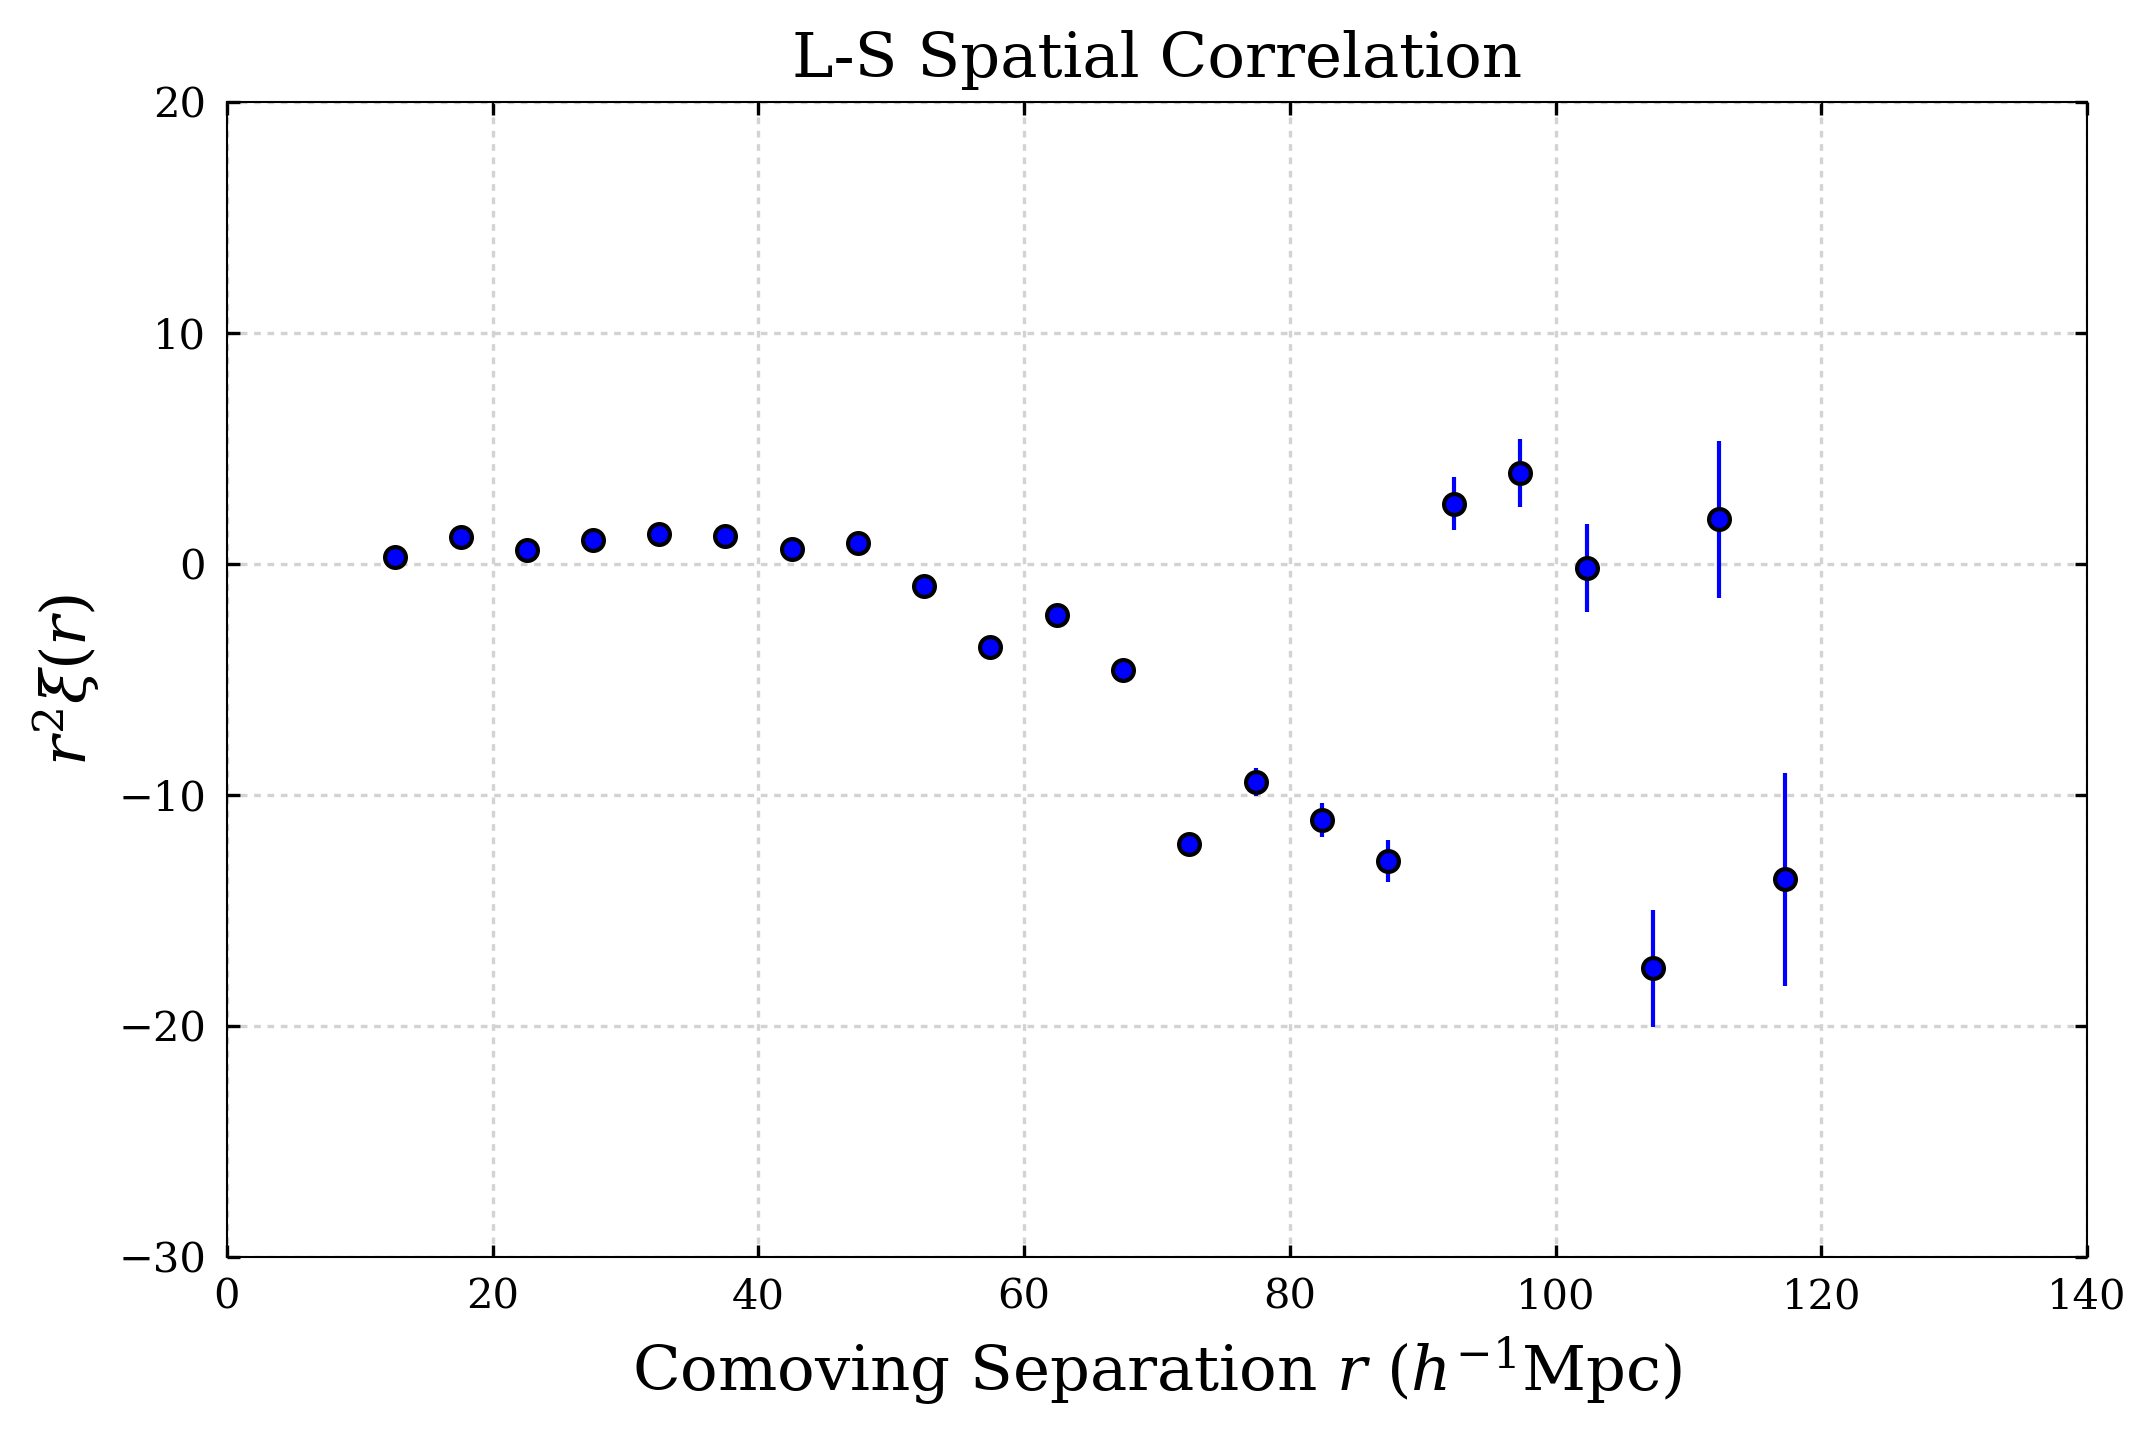

In [38]:
xmin, xmax = 10, 120
ymin, ymax = -30, 20
xlabels = np.arange(0, 160, 20)

tpcf_plot(r_5, rh_5, xi_5, sig_5,
          xlog=False, ylog=False,                            # log the axis
          xmin=xmin, xmax=xmax, xlabels=xlabels,             # x-axis
          ymin=ymin, ymax=ymax,                              # y-axis
          fig_path='graphs/spatial_anderson')

<a class="anchor" id="resources"></a>
# Resources and references

**Attached are some resources and "further reading" links relevant to this notebook.**

"Cosmolgical Distance Measurements", Scholarly Community Encyclopedia. https://encyclopedia.pub/entry/30206

"BOSS: Dark Energy and the Geometry of Space", SDSS-III. https://www.sdss3.org/surveys/boss.php

"Luminous Red Galaxies", SDSS-III. https://classic.sdss.org/dr7/products/general/edr_html/node53.html

"SDSS Data Release 12", SDSS. https://classic.sdss.org/dr7/products/general/edr_html/node53.htmlhttps://www.sdss4.org/dr12/

BOSS Data Download. https://fbeutler.github.io/hub/boss_papers.html

"A Detailed Look at Estimators for the Two-Point Correlation Function, their Variance and a Verification of the TreeCorr-Algorithm with LoTSS Data", Marian Biermann, Universität Bielefeld. https://www2.physik.uni-bielefeld.de/fileadmin/user_upload/theory_e6/Master_Theses/MA_MarianBiermann.pdf

**Papers referenced in this paper:**

[SDSS & Connolly et al 2002](https://arxiv.org/abs/astro-ph/0107417)

[Landy-Szalay et al 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...412...64L/)

[Eisenstein & Hu 1998](https://ui.adsabs.harvard.edu/abs/1998ApJ...496..605E/)

[Eisenstein et al 2004](https://iopscience.iop.org/article/10.1086/466512)

[Anderson et al 2012](https://arxiv.org/abs/1203.6594)